Задачи на основе инстанс-сегментации, которая приведена в файле "Mask R-CNN instance segmentation on custom dataset"

In [1]:
# Начнем с загрузки необходимых наборов данных, установки необходимых пакетов и их импорта.
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar

In [2]:
%pip install -qU torch_snippets==0.5 # вспомогательная библиотека для удобной работы с PyTorch (содержит полезные функции для загрузки данных, визуализации и т. д.).
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI' # Этот пакет нужен для работы с форматом аннотаций COCO (который используется в ADE20K).

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 40.4 MB/s eta 0:00:00
   ━━

In [3]:
from torch_snippets import *
from torch_snippets.inspector import inspect # Инструмент для отладки (показывает структуру данных).
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Класс для замены головы модели Faster R-CNN.
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor # Класс для замены головы модели Mask R-CNN.

from engine import train_one_epoch, evaluate # готовые циклы обучения/валидации из engine.py
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# пути к изображениям и аннотациям из ADE20K с помощью Glob из torch_snippets
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

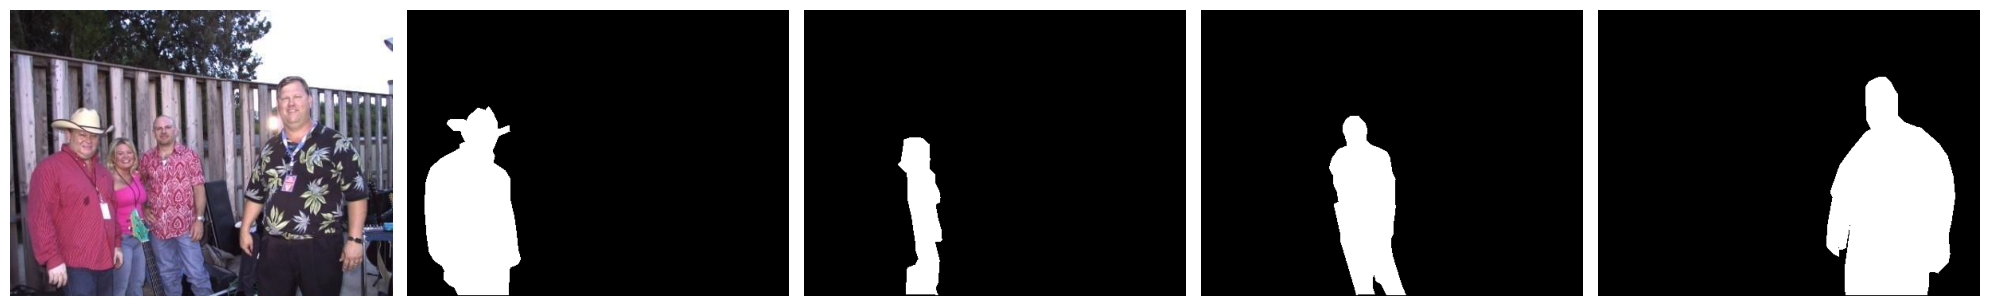

In [5]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1) # поиск и чтение изображения
an = read(find(f, all_annots), 1).transpose(2,0,1) # поиск и чтение аннотации
r,g,b = an # Семантические классы в красном канале, номера инстансов в зелёном канале, синий не используется
nzs = np.nonzero(r==4) # Выбор класса "person" (4), на выходе массив индектов
instances = np.unique(g[nzs]) # извлечение масок инстансов.
masks = np.zeros((len(instances), *r.shape)) # формируем массив масок по количеству инстансов
for ix,_id in enumerate(instances):
    masks[ix] = g==_id # # Маска для инстанса _id, коротко говоря формируем каждую маску

subplots([im, *masks], sz=20) # Вывод изображения и масок, где sz=20 — параметр, задающий размер области отображения (например, в дюймах или пикселях).

In [6]:
# Пробегаем по аннотациям и фильтруем аннотации, оставляя только те, которые содержат объекты класса "person" (класс 4 в ADE20K)
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:36<00:00, 135.29it/s]


In [7]:
from sklearn.model_selection import train_test_split # разбиваем
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [8]:
def get_transform(train): # трансформации
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [9]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N): # items-список id изображений, N-количество элементов в датасете
        self.items = items
        self.transforms = transforms
        self.N = N

    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1) # загрузка маски (предположительно в формате HWC → CHW)
        r,g,b = an # разделение на каналы (R, G, B) и далее получаем маски класса "person"
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks

    def __getitem__(self, ix): # получение элемента по индексу
        _id = self.items[ix] # получаем ID изображения
        img_path = f'images/training/{_id}.jpg' # соответственно изображение
        mask_path = f'annotations_instance/training/{_id}.png' # маска
        masks = self.get_mask(mask_path) # получаем маски
        obj_ids = np.arange(1, len(masks)+1) # список id объектов
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)

        # Обработка bounding boxes (ограничивающих рамок):
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i]) # координаты пикселей объекта
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):  # Если bbox слишком мал, расширяем его до 10x10
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32) # преобразуем в тензор

        # Подготовка target (целевых данных для модели)
        labels = torch.ones((num_objs,), dtype=torch.int64) # все объекты принадлежащие одному классу
        masks = torch.as_tensor(masks, dtype=torch.uint8) # маски в тензорном формате
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # площадь bbox
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # флаг "группа объектов" (0)
        image_id = torch.tensor([ix]) # ID изображения

        target = {} # словарь, ниже его заполняем
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target

    def __len__(self):
        return self.N

    def choose(self):
        return self[randint(len(self))]

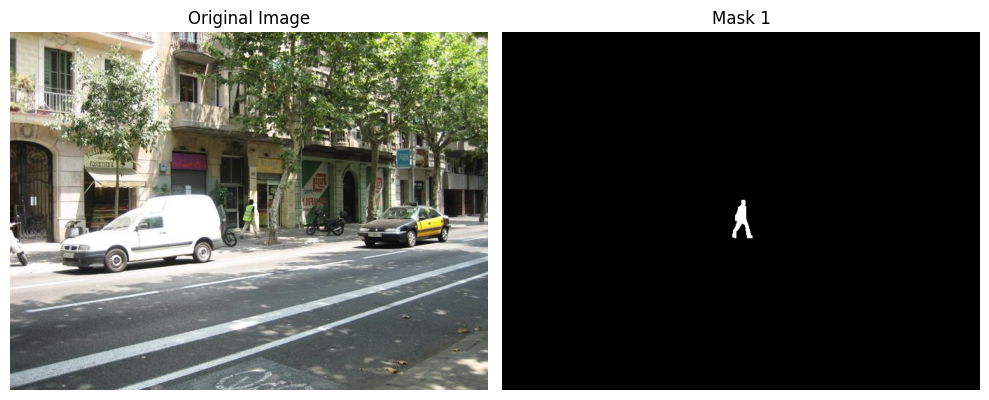

In [10]:
x = MasksDataset(trn_items, get_transform(train=True), N=100) # инициализация класса с передачей trn_items (списка идентификаторов изображений )
im,targ = x[0] # Получение конкретного примера, где im-тензор изображения, а targ-словарь с целевыми данными для обучения модели

# inspect(im,targ)
# subplots([im, *targ['masks']], sz=10)

# Функция для правильной визуализации
def visualize_sample(image, target):
    # Преобразуем изображение
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Меняем порядок каналов
        if image.max() <= 1.0:  # Если нормализовано [0,1]
            image = (image * 255).astype(np.uint8)

    # Преобразуем маски
    masks = []
    for mask in target['masks']:
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
        masks.append(mask)

    # Создаем фигуру
    n_subplots = 1 + len(masks)
    fig, axes = plt.subplots(1, n_subplots, figsize=(5*n_subplots, 5))

    # Если только 1 subplot, axes будет не списком
    if n_subplots == 1:
        axes = [axes]

    # Отображаем оригинальное изображение
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Отображаем маски
    for i, mask in enumerate(masks, 1):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем
visualize_sample(im, targ)

In [11]:
# Создает Mask R-CNN с измененными головами под наши классы
def get_model_instance_segmentation(num_classes):
    # загрузить предварительно обученную модель сегментации экземпляра на COCO
    # Загружается модель Mask R-CNN с backbone ResNet-50 и FPN (Feature Pyramid Network), FPN помогает работать с объектами разных масштабов
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # получить количество входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Замена головы для классификации объектов (bbox)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # теперь получите количество входных признаков для классификатора маски
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 # для более простых задач можно уменьшить
    # Замена головы для сегментации (маски)
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [12]:
model = get_model_instance_segmentation(2).to(device) # 2 = класс "person" + фон

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 176MB/s]


In [13]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# загрузчики
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [14]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad] # Собирает только те параметры модели, которые требуют градиенты (для обучения)
optimizer = torch.optim.SGD(params,
                            lr=0.005, # Скорость обучения, стандартная начальная скорость обучения для Mask R-CNN
                            momentum=0.9, # Инерция обновления, помогает быстрее сходиться и избегать локальных минимумов
                            weight_decay=0.0005) # L2-регуляризация, предотвращает переобучение через L2-регуляризацию

# Настройка планировщика скорости обучения
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, # StepLR - уменьшает скорость обучения в заданные моменты
                                                step_size=3, # каждые 3 эпохи будет срабатывать
                                                gamma=0.1) # новое LR = текущее LR * 0.1 (резкое уменьшение)

In [18]:
# Обучение модели
# Данный код выполняет тонкую настройку (fine-tuning) предобученной модели Mask R-CNN
num_epochs = 2

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/469]  eta: 0:05:28  lr: 0.000001  loss: 0.8702 (0.8702)  loss_classifier: 0.1200 (0.1200)  loss_box_reg: 0.1774 (0.1774)  loss_mask: 0.5257 (0.5257)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0373 (0.0373)  time: 0.7002  data: 0.0655  max mem: 4467
Epoch: [0]  [ 10/469]  eta: 0:06:05  lr: 0.000009  loss: 0.8006 (0.7751)  loss_classifier: 0.1311 (0.1298)  loss_box_reg: 0.2057 (0.2309)  loss_mask: 0.3092 (0.3565)  loss_objectness: 0.0154 (0.0331)  loss_rpn_box_reg: 0.0275 (0.0248)  time: 0.7957  data: 0.1557  max mem: 5440
Epoch: [0]  [ 20/469]  eta: 0:05:49  lr: 0.000018  loss: 0.7346 (0.7284)  loss_classifier: 0.0882 (0.1192)  loss_box_reg: 0.2014 (0.2264)  loss_mask: 0.3092 (0.3351)  loss_objectness: 0.0075 (0.0227)  loss_rpn_box_reg: 0.0105 (0.0249)  time: 0.7832  data: 0.1148  max mem: 5861
Epoch: [0]  [ 30/469]  eta: 0:05:19  lr: 0.000026  loss: 0.6322 (0.7204)  loss_classifier: 0.0882 (0.1124)  loss_box_reg: 0.1488 (0.2237)  loss_mask: 0.3356 (0.3373) 

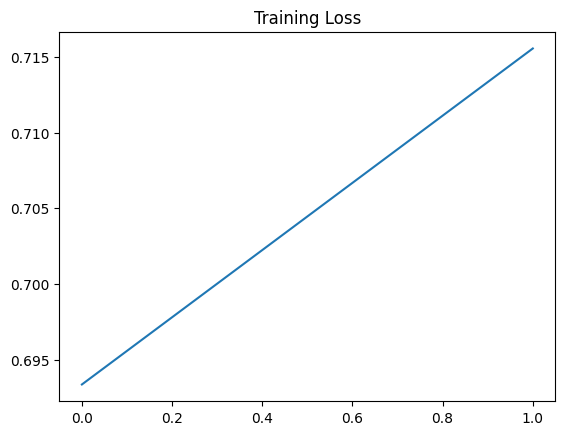

In [19]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

tensor([[[0.4039, 0.4510, 0.5255,  ..., 0.2588, 0.2196, 0.2667],
         [0.4196, 0.4039, 0.4431,  ..., 0.2392, 0.2196, 0.2392],
         [0.4118, 0.3922, 0.4235,  ..., 0.2431, 0.2431, 0.2431],
         ...,
         [0.1529, 0.1686, 0.1843,  ..., 0.1804, 0.1804, 0.1804],
         [0.2471, 0.2588, 0.2706,  ..., 0.1804, 0.1804, 0.1804],
         [0.3020, 0.3137, 0.3176,  ..., 0.1804, 0.1804, 0.1804]],

        [[0.4275, 0.4706, 0.5373,  ..., 0.1255, 0.0863, 0.1333],
         [0.4431, 0.4235, 0.4549,  ..., 0.1137, 0.0941, 0.1137],
         [0.4392, 0.4118, 0.4353,  ..., 0.1255, 0.1255, 0.1255],
         ...,
         [0.2275, 0.2431, 0.2588,  ..., 0.2431, 0.2431, 0.2431],
         [0.3137, 0.3255, 0.3373,  ..., 0.2431, 0.2431, 0.2431],
         [0.3686, 0.3804, 0.3843,  ..., 0.2431, 0.2431, 0.2431]],

        [[0.2784, 0.3529, 0.5020,  ..., 0.0275, 0.0000, 0.0353],
         [0.2941, 0.3059, 0.4118,  ..., 0.0157, 0.0000, 0.0157],
         [0.2784, 0.2941, 0.3922,  ..., 0.0235, 0.0235, 0.

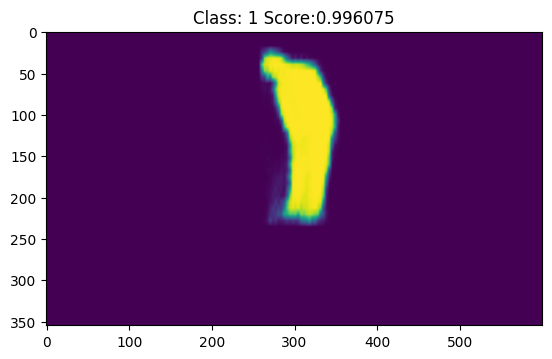

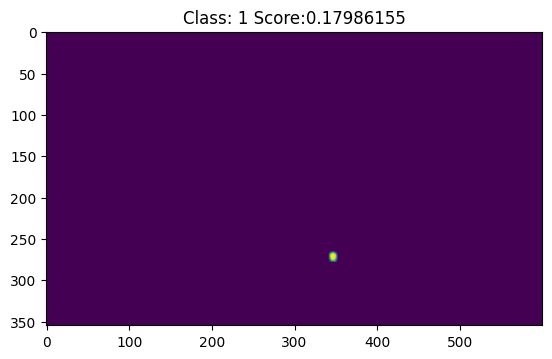

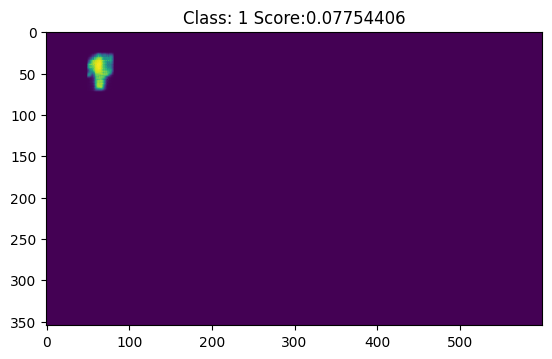

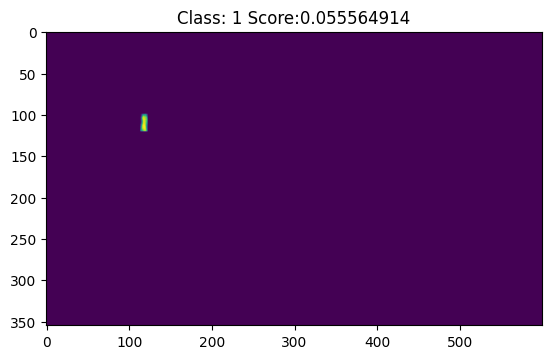

In [20]:
# Инференс обученной модели Mask R-CNN на тестовом изображении,
# визуализация исходного изображения и предсказанных масок объектов с указанием их классов и уверенности модели.
model.eval()
im = dataset_test[7][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks']\
                      [i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels']\
                   [i].cpu().numpy())+' Score:'+str(\
                  prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

**Задача 1**

Модифицируйте код вывода масок, чтобы отображались только объекты с confidence score > 0.7. Добавьте визуализацию bounding boxes прямо на исходном изображении с разными цветами для разных классов.

**Задача 2**

Добавьте текстовый отчет после обработки, который подсчитывает количество обнаруженных объектов каждого класса и выводит среднюю уверенность по классам.

In [53]:
threshold = 0.7

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class_names = {1: 'person'}
colors = {cls: tuple(np.random.rand(3,).tolist()) for cls in class_names}

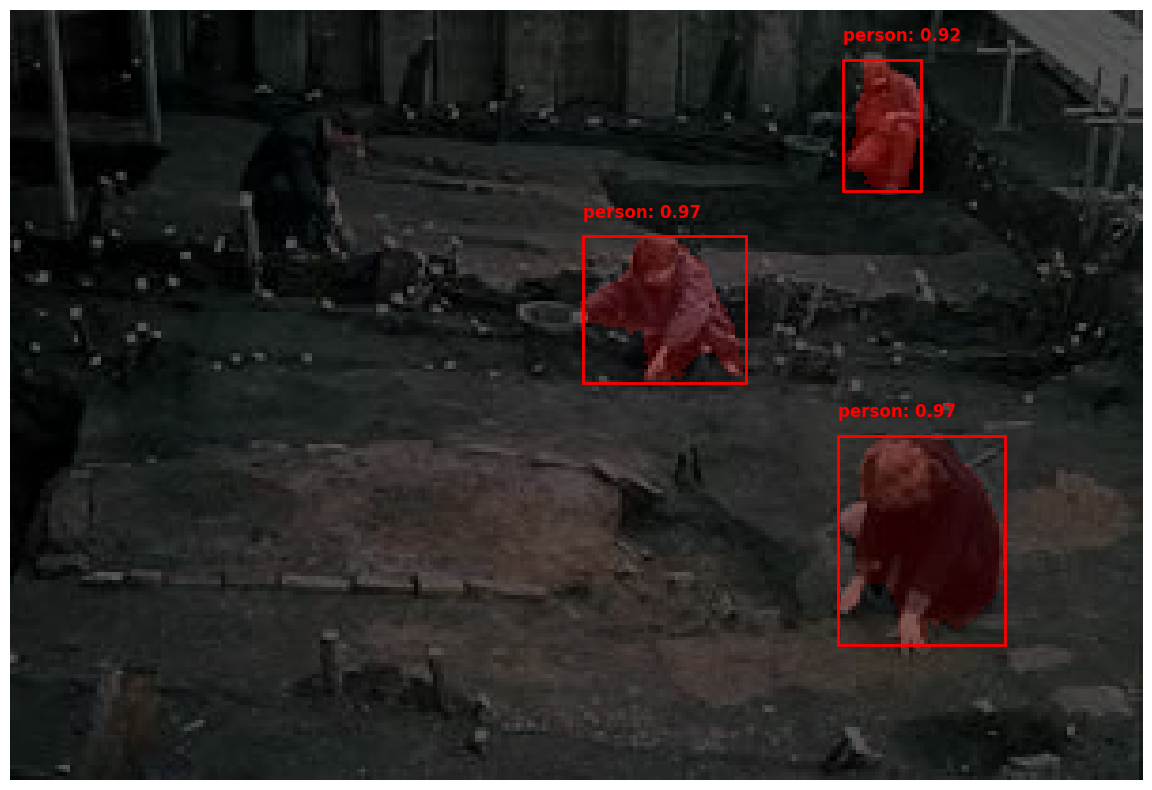

In [54]:
highlight_color = (1, 0, 0)

model.eval()
image, _ = dataset_test[15]
with torch.no_grad():
    pred = model([image.to(device)])[0]

boxes  = pred['boxes'].cpu().numpy()
labels = pred['labels'].cpu().numpy()
scores = pred['scores'].cpu().numpy()
masks  = pred['masks'][:, 0].cpu().numpy()

keep = scores > threshold
boxes, labels, scores, masks = boxes[keep], labels[keep], scores[keep], masks[keep]

fig, ax = plt.subplots(1, figsize=(12, 8))
img_np = image.permute(1, 2, 0).cpu().numpy()
if img_np.max() <= 1:
    img_np = (img_np * 255).astype(np.uint8)
ax.imshow(img_np)

for box, lbl, score, mask in zip(boxes, labels, scores, masks):
    if lbl == 1:
        color = highlight_color
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            box[0], box[1] - 5,
            f"person: {score:.2f}",
            color=color, fontsize=12, weight='bold'
        )
        bin_mask = (mask > 0.5).astype(np.uint8)
        colored_mask = np.zeros((bin_mask.shape[0], bin_mask.shape[1], 3), dtype=float)
        for c in range(3):
            colored_mask[..., c] = bin_mask * color[c]
        ax.imshow(colored_mask, alpha=0.3)

ax.axis('off')
plt.tight_layout()
plt.show()

In [55]:
from collections import defaultdict

counts = defaultdict(int)
sum_scores = defaultdict(float)

for lbl, score in zip(labels, scores):
    counts[lbl] += 1
    sum_scores[lbl] += score

for lbl in sorted(counts):
    cls_name = class_names.get(lbl, f'class_{lbl}')
    cnt = counts[lbl]
    avg_score = sum_scores[lbl] / cnt if cnt>0 else 0
    print(f"  - {cls_name}: {cnt} шт., средний confidence = {avg_score:.3f}")

- person: 3 шт., средний confidence = 0.953